# Project 2 - Source coding, data compression and channel coding

The goal of this second project is to apply some of the principles seen in the lectures about source coding, data compression and channel coding. We ask you to write a brief report (pdf format) collecting your answers to the different questions. All codes must be written in Python inside this Jupyter. Note that you can not change the content of locked cells or import any extra Python library than the ones already imported (numpy).

## Implementation

In this project, you will need to use implement source coding algorithms to answer several questions. Therefore, in this first part, you are asked to write several functions that implement two of the  algorithms seen in the theoretical lectures and one new algorithm described in the project statement. Remember that you need to fill in this Jupyter Notebook to answer these questions. Pay particular attention to the required input and output format of each function.

In [153]:
# [Locked Cell] You can not import any extra Python library in this Notebook.
import numpy as np

### Question 1
Implement a function that returns a binary Huffman code for a given probability distribution. Give the main steps of your implementation. Verify your code on Exercise 7 of the second exercise session (TP2), and report the output of your code for this example. Explain how to extend your function to generate a Huffman code of any (output) alphabet size. 


In [154]:
def merge(left, right, symbols_dict):
    left_keys = list(left[0])
    right_keys = list(right[0])

    for key in left_keys:
        symbols_dict[key].append('0')
    for key in right_keys:
        symbols_dict[key].append('1')

    merged_keys = left[0]+right[0]
    merged_values = left[1]+right[1]

    return (merged_keys, merged_values)
    

def Huffman_code(probability_dict):
    """
    Create the Huffman code for given probabilities  
    
    Arguments:
    ----------
    probability_dict:
      - keys: symbol as character or string
      - values: probability of the symbol as a float or double
      Example: {"A": 0.25, "B":0.5,"C":0.125,"D":0.125}
    
    Return:
    -------
    - codewords: dictionary with the name and the corresponding codeword 
      - keys: symbol as character or string
      - values: associated codeword as a character or a string    
      Example: {"A": "10", "B":"0","C":"111","D":"110"}
    
    """

    # Convert the dictionary to a list of tuples
    probability_list = list(probability_dict.items())

    symbols_dict = {}
    for key in probability_dict.keys():
        symbols_dict[key] = []

    for i in range(len(probability_list)):
        probability_list[i] = ([probability_list[i][0]], probability_list[i][1])

    trees = []
    for i in range(len(probability_list)):
        trees.append(probability_list[i])

    # merge the trees until there is only one tree left by using the merge function
    while len(trees) > 1:
        trees.sort(key=lambda x: x[1])
        left = trees.pop(0)
        right = trees.pop(0)
        merged = merge(left, right, symbols_dict)
        trees.append(merged)

    # reverse the order of the codewords and convert the list to a string
    for key in symbols_dict.keys():
        symbols_dict[key] = symbols_dict[key][::-1]
        symbols_dict[key] = ''.join(symbols_dict[key])

    return symbols_dict

In [155]:
prob_dict = {"A":0.05,"B":0.10,"C":0.15,"D":0.15,"E":0.2,"F":0.35}
print(Huffman_code(prob_dict))

{'A': '000', 'B': '001', 'C': '100', 'D': '101', 'E': '01', 'F': '11'}


### Question 2

Given a sequence of symbols, implement a function that returns a dictionary and the encoded sequence using the on-line Lempel-Ziv algorithm (see State of the art in data compression, slide 50/53). Reproduce and report the example given in the course. 

In [156]:
def LZ_online(sequence):
    """
    The on-line Lempel-Ziv algorithm given a sequence of symbols  
    Arguments:
    ----------
    - sequence : Sequence of symbols in the string format
    
    Return:
    -------
    - dictionary : the computed dictionnary in the form:
        - keys: symbol as character or string
        - values: associated codeword as a tuple composed of the entry index (integer) and a binarized adress with one appended symbol (character or string)
        Example: {'': (0, ''), '0': (1, '0'), '1': (2, '01'), '00': (3, '010'), '10': (4, '100')}
    - encoded_sequence : the encoded sequence in the string format
    """
    dict = {'': (0, '')}
    encoded = ''
    next_index = 1
    i = 0

    while i < len(sequence):

        prefix = ''
        buffered_prefix = ''
        j = i
        next_index_log = np.ceil(np.log2(next_index))

        while prefix in dict and j < len(sequence):
            buffered_prefix = prefix
            prefix += sequence[j]
            j += 1

        if prefix not in dict and len(prefix) == 1:

            prefix = buffered_prefix
            prefix_dict = dict[prefix]
            index = '{0:b}'.format(prefix_dict[0])
            encoded += sequence[j - 1].zfill(int(next_index_log + 1))

            dict[prefix + sequence[j - 1]] = (next_index, sequence[j - 1].zfill((int(next_index_log + 1))))
            next_index += 1
            i = j

        if prefix not in dict and len(prefix) > 1:
            prefix = buffered_prefix
            prefix_dict = dict[prefix]
            index = '{0:b}'.format(prefix_dict[0])
            encoded += index.zfill(int(next_index_log)) + sequence[j - 1]

            dict[prefix + sequence[j - 1]] = (next_index, index.zfill(int(next_index_log)) + sequence[j - 1])
            next_index += 1
            i = j
        else:
                i = j

    return dict, encoded

In [157]:
t_seq = '1011010100010'
u_seq = '100011101100001000010'

dict, u_lz = LZ_online(t_seq)
print(u_lz)
print(u_seq == u_lz)

print(len(t_seq)*8)
print(len(u_lz))

100011101100001000010
True
104
21


### Question 4

Implement a function that returns the encoded sequence using the LZ77 algorithm as described by the algorithm below given an input string and a sliding window size l. Reproduce the example given in Figure 2 with window_size=7.

In [158]:
def best_match(sliding_window, look_ahead_buffer):
    """
    Find the best match between the sliding window and the look ahead buffer
    
    Arguments:
    ----------
    - sliding_window : sliding window as a string
    - look_ahead_buffer : look ahead buffer as a string
    
    Return:
    -------
    - best_match : tuple composed of the length of the match (integer) and the index of the match in the sliding window (integer)
    """
    d = 0 # distance to the start of prefix
    p = 0 # length of prefix
    c = look_ahead_buffer[0] # next character in the look ahead buffer
    i = 0

    while i < len(sliding_window):
        substring = look_ahead_buffer[:i+1]
        if substring in sliding_window:
            d = len(sliding_window) - sliding_window.rfind(substring)
            p = len(substring)
            if p + 1 > len(look_ahead_buffer):
                c = None
            else:
                c = look_ahead_buffer[i + 1]
        else :
            break
        i += 1

    if c is not None:
        best_match = str(d) + str(p) + c
    else:
        best_match = str(d) + str(p)

    return best_match, p+1


def LZ77(sequence, window_size=7):
    """
    The Lempel-Ziv 77 algorithm given a sequence of symbols and the sliding window size

    Arguments:
    ----------
    - sequence : Sequence of symbols in the string format
    - window_size : sliding window size as an integer

    Return:
    -------
    - encoded_sequence : the encoded sequence in the string format
    """
    encoded_sequence = ''
    sliding_window = ''
    look_ahead_buffer = sequence
    
    while len(look_ahead_buffer) > 0:
        match, slide = best_match(sliding_window, look_ahead_buffer)
        encoded_sequence += match
        sliding_window += look_ahead_buffer[:slide]
        look_ahead_buffer = look_ahead_buffer[slide:]
        sliding_window = sliding_window[-window_size:]

    return encoded_sequence

In [159]:
sequence = 'abracadabra'
print(LZ77(sequence,7))

sequence = 'abracadabrad'
print(LZ77(sequence,7))

sequence = 'abracadabraa'
print(LZ77(sequence,7))

sequence = 'abracadabraaa'
print(LZ77(sequence,7))

00a00b00r31c21d74
00a00b00r31c21d74d
00a00b00r31c21d74a
00a00b00r31c21d74a11


In [160]:
# [Locked Cell] Evaluation of your functions by the examiner. 
# You don't have access to the evaluation, this will be done by the examiner.
# Therefore, this cell will return nothing for the students.
import os
if os.path.isfile("private_evaluation.py"):
    from private_evaluation import unit_tests
    unit_tests(Huffman_code, LZ_online, LZ77)

## Source coding and reversible (lossless) data compression

Source coding and reversible (lossless) data compression
An image is a visual representation of an object or scene that can be captured and stored in a digital format. For grayscale images, each pixel is assigned a brightness value between 0 and 255 to represent the different shades of gray. One popular format for storing and transmitting grayscale images is the Portable Network Graphics (PNG) format, which is a lossless compression format. This allows PNG images to be smaller in size than raw image formats without sacrificing image quality. In this assignment, you are given a pixel.txt containing the original raw grayscale image pixels of size 512x512 encoded in bytes, where the pixels are ordered from left to right and top to bottom. Additionally, you are provided with the same image that has been encoded in the PNG format and transformed in bytes. For simplicity each byte is represented in the files with its corresponding hexadecimal representation.

### Question 5

Write a function to read and display both images (you may use external libraries). What is the number of symbols required to represent all possible images in both image representations? What is the length (in bytes) of both files?

In [161]:
from PIL import Image
from io import BytesIO

print("Initial number of symbols : ", 512*512)

raw_path = "data/pixel.txt"
png_path = "data/PNG.txt"

with open(raw_path, "r") as raw:
    raw_data = raw.read()

raw_data.replace('\r\n', ' ')
raw_data = bytes.fromhex(raw_data)
print("Length of the pixel file ", len(raw_data))

raw_img = Image.frombytes("L", (512, 512), raw_data)
#raw_img.show(title="Raw image")
raw_img.save("data/raw.png")

with open(png_path, "rb") as png:
    png_data = png.read()

png_data = bytes.fromhex(png_data.decode("utf-8"))
print("Length of the PNG file ", len(png_data))

png_img = Image.open(BytesIO(png_data))
#png_img.show(title="PNG image")
png_img.save("data/png.png")

Initial number of symbols :  262144
Length of the pixel file  262144
Length of the PNG file  160552


### Question 6

Estimate the marginal probability distribution of all symbols (in hexadecimal representation) from the given PNG representation sequence of the image, and determine the corresponding binary Huffman code and the encoded PNG sequence. Give the total length of the encoded PNG sequence and the compression rate.

In [162]:
with open("data/PNG.txt", "rb") as png:
    png_data = png.read().replace(b'\r\n', b'')
    png_data = png_data.decode("utf-8")

png_data = png_data.replace(" ", "")
png_data = np.array([png_data[i:i+2] for i in range(0, len(png_data), 2)])
print("Original PNG file: ", png_data)
length_data = len(png_data)
print("Length of the PNG file (bits):", length_data*8)

# ascii translation
ascii_data = []
for symbol in png_data:
    if int(symbol, 16) == 48:
        ascii_data.append(chr(1000))
    elif int(symbol, 16) == 49:
        ascii_data.append(chr(1001))
    elif int(symbol, 16) <= 31:
        ascii_data.append(chr(int(symbol, 16) + 0xFF))
    else:
        ascii_data.append(chr(int(symbol, 16)))

unique, counts = np.unique(ascii_data, return_counts=True)

dict = {}
for i in range(len(unique)):
    dict[unique[i]] = counts[i]/length_data

huffman_code = Huffman_code(dict)

encoded = ''
for symbol in ascii_data:
    encoded += huffman_code[symbol]

print("Number of unique symbols in the PNG file:", len(dict))
print("Length of the encoded PNG file (bits):", len(encoded))
print("Compression ratio:", length_data*8/len(encoded))


Original PNG file:  ['89' '50' '4E' ... '42' '60' '82']
Length of the PNG file (bits): 1284416
Number of unique symbols in the PNG file: 255
Length of the encoded PNG file (bits): 1280279
Compression ratio: 1.0032313269217101


### Question 7

Give the expected average length for your Huffman code. Compare this value with (a) the empirical average length, and (b) theoretical bound(s). Justify.

In [163]:
theoretical_length = 0
kraft = 0
shannon = 0

# theory
for code in huffman_code:
    kraft += 2**(-len(huffman_code[code]))
    theoretical_length += len(huffman_code[code])*dict[code]
    shannon += dict[code]*np.log2(1/dict[code])

print("Kraft inequality respected ?:", kraft <= 1)
print("Theoretical length of the encoded PNG file (bits/symbol):", theoretical_length)
print("Shannon entropy (bits/symbol):", shannon)

# empirical
empirical_length = 0

for i in range(1000):
    random_seq = np.random.choice(list(huffman_code.keys()), size=1000, p=list(dict.values()))
    random_seq = ''.join(random_seq)

    encoded = ''
    for symbol in random_seq:
        encoded += huffman_code[symbol]

    empirical_length += len(encoded)/1000

print("Empirical length of the encoded PNG file (bits/symbol):", empirical_length/1000)

Kraft inequality respected ?: True
Theoretical length of the encoded PNG file (bits/symbol): 7.974232647366582
Shannon entropy (bits/symbol): 7.957359831200671
Empirical length of the encoded PNG file (bits/symbol): 7.973375999999992


### Question 8

Plot the evolution of the empirical average length of the encoded PNG using your Huffman code for increasing input sequence lengths.

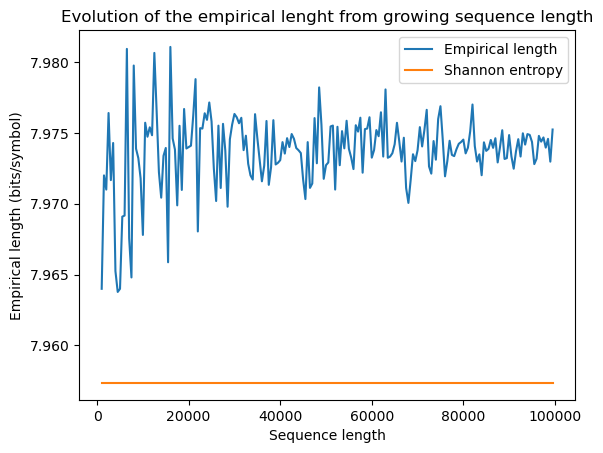

In [164]:
import matplotlib.pyplot as plt

sequence_lengths = range(1000, 100000, 500)
empirical_lengths = []

for length in sequence_lengths:
    random_seq = np.random.choice(list(huffman_code.keys()), size=length, p=list(dict.values()))
    random_seq = ''.join(random_seq)

    encoded = ''
    for symbol in random_seq:
        encoded += huffman_code[symbol]

    empirical_lengths.append(len(encoded)/length)

plt.plot(sequence_lengths, empirical_lengths, label="Empirical length")
plt.plot(sequence_lengths, [shannon]*len(sequence_lengths), label="Shannon entropy")
plt.xlabel("Sequence length")
plt.ylabel("Empirical length (bits/symbol)")
plt.legend()
plt.title("Evolution of the empirical lenght from growing sequence length")
plt.savefig("figs/empirical_length")
plt.show()

### Question 9

Encode the PNG sequence using the on-line Lempel-Ziv algorithm. Give the total length of the encoded sequence and the compression rate.

In [165]:
lz_online_encodeing = LZ_online(ascii_data)

bits = 0

for symbol in lz_online_encodeing[1]:
    if symbol == '0' or symbol == '1':
        bits += 1
    else:
        bits += 8

print("Length of the encoded PNG file (bits):", bits)
print("Compression ratio:", len(ascii_data)*8/bits)

Length of the encoded PNG file (bits): 1537929
Compression ratio: 0.835159490457622


### Question 10

Encode the PNG sequence using the LZ77 algorithm with window_size=7. Give the total length of the encoded sequence and the compression rate.

In [166]:
str_ascii = ''.join(ascii_data)
lz_77_encodeing = LZ77(str_ascii, 7)

# number 0 -> 6 coded on 3 bits
# two of these numbers per symbol
# 8 bits per symbol

bits_symbol = (3+3+8)/3

bits_lz_77_encodeing = len(lz_77_encodeing)*bits_symbol

print("Length of the encoded PNG file (bits):", bits_lz_77_encodeing)
print("Compression ratio:", (len(ascii_data)*8)/bits_lz_77_encodeing)

Length of the encoded PNG file (bits): 2168838.0
Compression ratio: 0.5922138951825816


### Question 12

Encode the PNG using one of the combinations of LZ77 and Huffman algorithms you proposed in the previous question. Give the total length of the encoded PNG sequence and the compression rate.

In [167]:
# encode huffman before lz77

# ascii_data

encode_huffman = ''
for symbol in ascii_data:
    encode_huffman += huffman_code[symbol]

encode_lz77 = LZ77(encode_huffman, 7)

# number 0 -> 6 coded on 3 bits
# two of these numbers per symbol
# 1 bit per symbol (binary thanks to huffman)

bits_symbol = (3+3+1)/3
bits_combination = len(encode_lz77)*bits_symbol

print("Length of the encoded PNG file (bits):", bits_combination)
print("Compression ratio:", (len(ascii_data)*8)/bits_combination)

Length of the encoded PNG file (bits): 2429991.666666667
Compression ratio: 0.5285680677917276


### Question 13

Report the total lengths and compression rates using (a) LZ77 and (b) the combination of LZ77 and Huffman, to encode the PNG sequence for different values of the sliding window size (use sliding window sizes from 1 to 11000 with a step of 1000). Compare your result with the total length and compression rate obtained using the on-line Lempel-Ziv algorithm. Discuss your results.

In [168]:
from tqdm import tqdm

sliding_windows = range(1, 11002, 1000)

lz77_lengths = []
lz77_compress_rates = []

combination_lengths = []
combination_compress_rates = []

ascii_data_combination = ascii_data.copy()
ascii_data_lz77 = ''.join(ascii_data)

for window in tqdm(sliding_windows):
    lz77_lengths.append(len(LZ77(ascii_data_lz77, window)))
    lz77_compress_rates.append((len(ascii_data)*8)/(len(LZ77(ascii_data_lz77, window))*((3+3+8)/3)))

    ascii_data_combination = ''.join(ascii_data_combination)
    encode_huffman = ''
    for symbol in ascii_data_combination:
        encode_huffman += huffman_code[symbol]

    encode_lz77 = LZ77(encode_huffman, window)

    bits_symbol = (3+3+1)/3
    bits_combination = len(encode_lz77)*bits_symbol

    combination_lengths.append(bits_combination)
    combination_compress_rates.append((len(ascii_data)*8)/bits_combination)

100%|██████████| 12/12 [04:07<00:00, 20.60s/it]


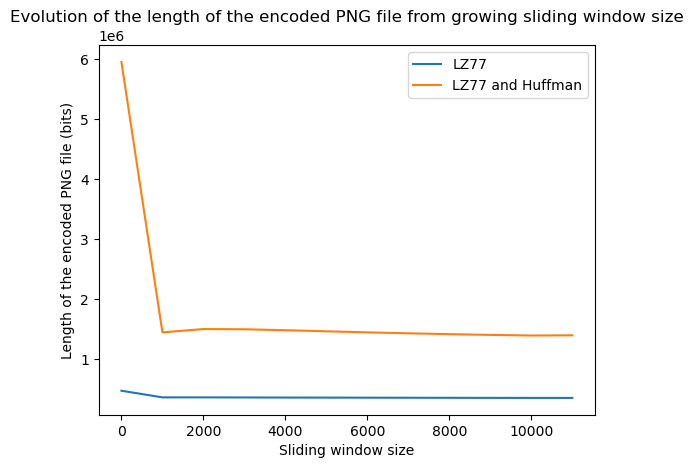

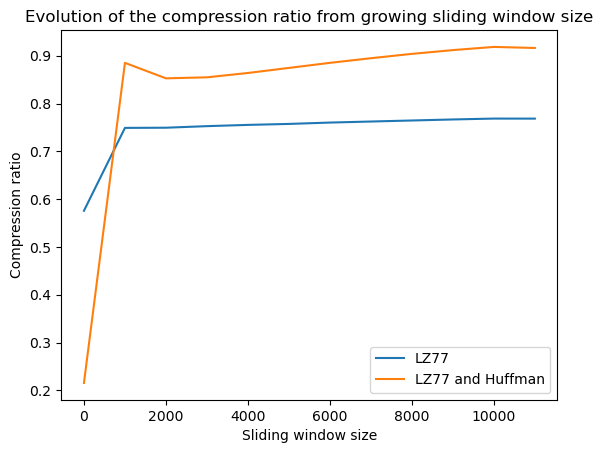

In [169]:

plt.plot(sliding_windows, lz77_lengths, label="LZ77")
plt.plot(sliding_windows, combination_lengths, label="LZ77 and Huffman")
plt.xlabel("Sliding window size")
plt.ylabel("Length of the encoded PNG file (bits)")
plt.legend()
plt.title("Evolution of the length of the encoded PNG file from growing sliding window size")
plt.savefig("figs/length_sliding_window")
plt.show()

plt.plot(sliding_windows, lz77_compress_rates, label="LZ77")
plt.plot(sliding_windows, combination_compress_rates, label="LZ77 and Huffman")
plt.xlabel("Sliding window size")
plt.ylabel("Compression ratio")
plt.legend()
plt.title("Evolution of the compression ratio from growing sliding window size")
plt.savefig("figs/compression_ratio_sliding_window")
plt.show()

### Question 14

Instead of encoding the PNG sequence, encode directly the pixel values with the binary Huffman algorithm. Give the average expected length, the experimental length of the encoded text and the compression rate.

In [170]:
with open("data/pixel.txt", "rb") as pixel:
    pixel_data = pixel.read().replace(b'\r\n', b'')
    pixel_data = pixel_data.decode("utf-8")

pixel_data = pixel_data.replace(" ", "")
pixel_data = np.array([pixel_data[i:i+2] for i in range(0, len(pixel_data), 2)])
print("Original pixel file: ", pixel_data)
length_pixel_data = len(pixel_data)
print("Length of the pixel file (bits):", length_pixel_data*8)

# ascii translation
ascii_pixel_data = []
for symbol in pixel_data:
    if int(symbol, 16) == 48:
        ascii_data.append(chr(1000))
    elif int(symbol, 16) == 49:
        ascii_pixel_data.append(chr(1001))
    elif int(symbol, 16) <= 31:
        ascii_pixel_data.append(chr(int(symbol, 16) + 0xFF))
    else:
        ascii_pixel_data.append(chr(int(symbol, 16)))

unique_pixel, counts_pixel = np.unique(ascii_pixel_data, return_counts=True)

dict_pixel = {}
for i in range(len(unique_pixel)):
    dict_pixel[unique_pixel[i]] = counts[i]/length_pixel_data

huffman_code_pixel = Huffman_code(dict_pixel)

theoretical_length_pixel = 0
for symbol in dict_pixel:
    theoretical_length_pixel += dict_pixel[symbol]*len(huffman_code_pixel[symbol])

encoded_pixel = ''

for symbol in ascii_pixel_data:
    encoded_pixel += huffman_code_pixel[symbol]

print("Number of unique symbols in the pixel file:", len(dict_pixel))
print("Theoretical length of the encoded pixel file (bits):", theoretical_length_pixel)
print("Length of the encoded pixel file (bits):", len(encoded_pixel))
print("Compression ratio:", ((length_pixel_data*8)/len(encoded_pixel)))

Original pixel file:  ['00' '00' '00' ... '0F' '00' '28']
Length of the pixel file (bits): 2097152
Number of unique symbols in the pixel file: 151
Theoretical length of the encoded pixel file (bits): 2.490753173828125
Length of the encoded pixel file (bits): 1946290
Compression ratio: 1.0775126008970914


## Channel coding

Consider a text document that is sent through a noisy communication channel. This document may contain important information such as business reports, academic papers, or personal messages. The text file may be encoded using ASCII, which uses 8 bits per character. This means that each character in the text document can be represented by a sequence of 8 binary digits, or bits. The channel used for transmission is a binary symmetric channel, which means that the transmitted bits can be flipped with a certain probability of error. The probability of error for this channel is 0.02, which means that 2% of the transmitted bits are expected to be flipped during transmission. This can result in errors in the received text, which can lead to misunderstandings or loss of important information. Therefore, it is important to develop techniques to ensure the accurate and reliable transmission of the text document over the noisy communication channel.

### Question 16

Implement a function to read the text document and encode the text signal using the binary ASCII fixed-length binary code. Count the number of bits required for the text provided with this assignment (text.txt).

In [171]:
# Write here your codes for questions 16 to 21 (you may delete this comment)
def turn_to_binary(path):
# Take the path of a txt file and turn it into a string of bit according to the ASCII rules.
    binary_text = []
    with open(path, 'r') as file:
        text = file.read()
    binary_text = ''.join(format(ord(char), '08b') for char in text)
    return binary_text
binary = turn_to_binary("data/text.txt")
print(len(binary))
np_binary = np.array(list(binary), dtype=int)

18088


### Question 17

Simulate the channel effect on the binary text signal. Then decode the text signal and display the decoded text. What do you notice?

In [172]:
def create_noise(binary_text, error_rate):
    #Take the string of bits and add an error rate to this string
    noisy_bits = [bit if np.random.rand() > error_rate else '1' if bit == '0' else '0' for bit in binary_text]
    return ''.join(noisy_bits)

def turn_to_txt(binary_text):
    #Take a text in binary and turn it to a string of char according to the ASCII rules.
    return ''.join(chr(int(binary_text[i*8:i*8+8],2)) for i in range(len(binary_text)//8))

### Question 18

Instead of sending directly through the channel the binary text signal, you will first introduce some redundancy. To do that, implement a function that returns the Hamming (7,4) code for a given sequence of binary symbols. Then, using your function, encode the binary text signal (from question 16).

In [173]:
G = np.array([[1, 0, 0, 0, 1, 0, 1],
              [0, 1, 0, 0, 1, 1, 0],
              [0, 0, 1, 0, 1, 1, 1],
              [0, 0, 0, 1, 0, 1, 1]])

def hamming_code(G, np_binary):
    np_binary = np_binary.reshape(int(len(np_binary)/4),4)
    hamming_code = [ np.mod( G.T @ bits , 2).tolist() for bits in np_binary]
    return np.array(hamming_code)

### Question 19

Simulate the channel effect on the binary text signal with redundancy. Then decode the binary text signal. Display the decoded text. What do you notice? Explain your decoding procedure.

In [174]:
def hamming_decode(G, hammingcode):
    l = ''
    for bits in hammingcode:
        s = []
        test = np.mod( G.T @ bits[:4] , 2)
        for i in range(len(bits[4:])):
            s.append(bits[i+4]^test[i+4]) 
        s = np.array(s)       
        if np.sum(s) == 0: 
           l_bis = ''.join(bits[:4].flatten().astype(str))
           l = l+ l_bis
        else:
            error = int(''.join(map(str, s)), 2)
            if error == 1: 
                bits[6] = (bits[6] + 1) % 2
            if error == 2: 
                bits[5] = (bits[5] + 1) % 2
            if error == 4: 
                bits[4] = (bits[4] + 1) % 2
            if error == 3: 
                bits[3] = (bits[3] + 1) % 2
            if error == 5: 
                bits[0] = (bits[0] + 1) % 2
            if error == 6: 
                bits[1] = (bits[1] + 1) % 2
            if error == 7: 
                bits[2] = (bits[2] + 1) % 2
            l_bis = ''.join(bits[:4].flatten().astype(str))
            l = l+ l_bis  
    return l
hammingcode = hamming_code( G,np_binary)
binary_bit = hamming_decode(G,hammingcode)
turn_to_txt(binary_bit)


'THE BOY WHO LIVED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you\'d expect to be involved in anything strange or mysterious, because they just didn\'t hold with such nonsense. Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursley s had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn\'t think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley\'s sister, but they hadn

In [175]:
binary = turn_to_binary("data/text.txt")
np_binary = np.array(list(binary), dtype=int)
hammingcode = hamming_code( G,np_binary)
str_hammingcode = ''.join(hammingcode.flatten().astype(str))
noise_binary = create_noise(str_hammingcode, 0.02)
np_noise_binary = np.array(list(noise_binary), dtype=int)
np_noise_hammingcode= np_noise_binary.reshape(int(len(np_noise_binary)/7),7)
binary_bit = hamming_decode(G,np_noise_hammingcode)
turn_to_txt(binary_bit)

'THE BOY WHO L)VED Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. Thåy were the last people you\'d expect to be involved in anything strange or mysterious, because they just didn\'t hold with such nonsense. Mr. Durslcy was the director of a firm cal,ed Grunnings, which made drills. He was a big< beefy mao with hardly any neck, although he did!have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as shµ spent so much of her time craning over garden fences, spying on the@neighbors. The Dursley s had á small son c±lled Dudley and in their opinion\xa0there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. Theq didn\'t think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Dursley\'s sister, but they h

### Question 20

Given the text document encoded in binary ASCII, implement a Python program to simulate transmission over a binary symmetric channel with a noise probability ranging from 0 to 0.5, with a step of 0.01. Compute the per character error rate for each noise probability, both with and without Hamming (7,4) code. Plot the per character error rate as a function of the noise probability, and compare the performance with and without Hamming (7,4) code.

In [176]:
def error_rate(str1, str2):
    if len(str1) != len(str2):
        raise ValueError("The two strings must have the same length")
    num_err=0
    for i in range(len(str1)):
        if str1[i] != str2[i]:
            num_err = 1 + num_err
    error = (num_err / len(str1))
    return error 
error_rate(binary_bit, binary)

0.0030959752321981426

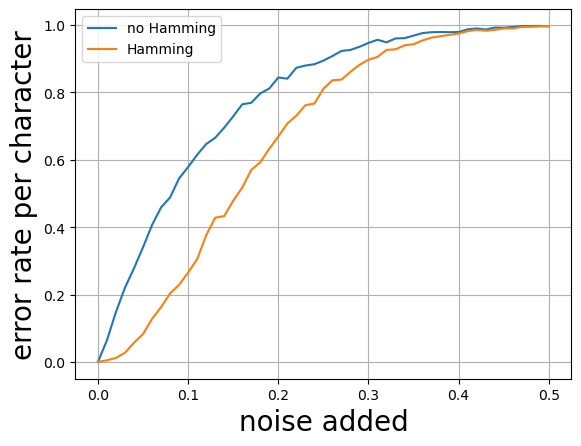

In [177]:
import matplotlib.pyplot as plt
def get_error(binary):
    l = []
    l_hamming = []
    text = turn_to_txt(binary)
    for error in range(0,51, 1):
        np_binary = np.array(list(binary), dtype=int)
        hammingcode = hamming_code( G,np_binary)
        hammingbinary = ''.join(hammingcode.flatten().astype(str))
        noise_hamming = create_noise(hammingbinary, error/100)
        noise_binary = create_noise(binary, error/100)
        np_noise_hamming= np.array(list(noise_hamming), dtype=int)
        np_noise_hamming = np_noise_hamming.reshape(int(len(np_noise_hamming)/7),7)
        decode_hamming = hamming_decode(G,np_noise_hamming)
        noise_txt = turn_to_txt(noise_binary)
        hamming_txt = turn_to_txt(decode_hamming)
        l.append(error_rate(noise_txt, text))
        l_hamming.append(error_rate(hamming_txt, text))

    x = np.array(range(0,51, 1))/100
    plt.plot(x, l, label = "no Hamming")
    plt.plot(x, l_hamming, label = "Hamming")
    plt.ylabel('error rate per character', fontsize=20)
    plt.xlabel('noise added', fontsize=20)
    plt.legend()
    plt.grid()
    plt.savefig("figs/hamming.png")
    return 
get_error(binary)